In [1]:
#Solving Time Series Problems Using Simple RNN

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.utils import np_utils

In [5]:
df = pd.read_csv('airline-passengers.csv')
df.sort_index(inplace=True)
df.tail(4)

,Month,Passengers
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [6]:
df.shape

(144, 2)

<Axes: >

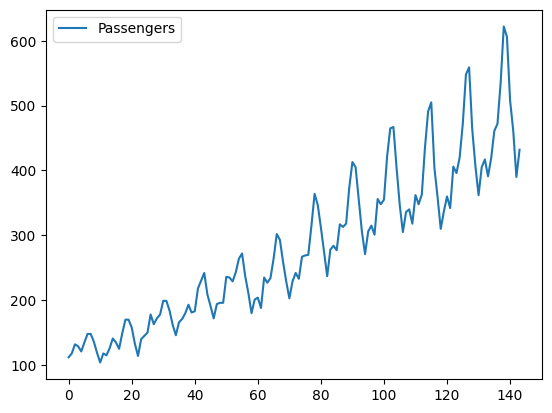

In [7]:
df.plot()

Data Preprocessing

In [8]:
#Check for null values
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [9]:
#Check Data Range
print('Min', np.min(df))
print('Max', np.max(df))

Min Month         1949-01
Passengers        104
dtype: object
Max Month         1960-12
Passengers        622
dtype: object


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


**Drop the month column**


*   month column serves just a representational need



In [10]:
df.drop("Month", axis=1, inplace=True)

In [11]:
df.shape

(144, 1)



*   lstms are sensitive to sclaing. Specifically when we use activation functions like sigmoid or tanh


*   A good practice is to rescale the data to the range of o to 1
*   This is also called normalization or standardization.


*  MinMaxScaler library helps in scaling








In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

**Checking the Scaled Data**

In [14]:
type(scaled)

numpy.ndarray

In [15]:
scaled.ndim

2

In [16]:
scaled.shape

(144, 1)

In [17]:
scaled

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

**Split Data - Points to be considered for time series problems**



*  Splitting the dataset into training or text
*   Usual methodology to split data into train and test is by using

     *  sklearn.model_selection import train_test_split
     *  X_train, X_test, y_train, y_test = train_test_split(X, y)


*  With timeseries the above approach will not work. Because, above methodology of splitting can make

  * an observation at time step t can be in training data set   

 *  another observation at time step t+1 can go to test data set
 *  Observations in our time series datasets are not independent.

 *  As a simple example, if your observations are autocorrelated, having an observation at time t in the training set and another observation at time t+1 in the test set would cause a trouble.
*   A model which knows the former naturally predict the latter well. In that case, the test score will be too optimistic about the predictive power of the model.









In [18]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

In [19]:
train_size

100

In [20]:
test_size

144

In [21]:
#Split the data - remember this is not a typical train test split using sci-kit learn
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 100
test: 44


**Build Input and Output data**

for both Training and Test

**Build_Ts_Data-Create a new function**



* The function takes two arguments:

 *  Ts_Dataset, is a NumPy array that we want to convert into a dataset,
 *Ts_Window - is the number of previous time steps to use as input variables to predict the next time period — in this example, we have defaulted to 1.

* This default will create a dataset where

 * dataX is the number of passengers at a given time (t) and
 * dataY is the number of passengers at the next time (t + 1). orig predict 100 122 122 133 133

In [22]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):

        ### initialize the list that houses the number of passengers at time t
    dataX, dataY = [], []

    for i in range(len(dataset)-window):

        a = dataset[i:(i+window), 0]
        dataX.append(a)
        dataY.append(dataset[i + window, 0])

    return np.array(dataX), np.array(dataY)

In [23]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

In [24]:
X_train.shape

(99, 1)

In [25]:
X_test.shape

(43, 1)

In [26]:
y_train.shape

(99,)

In [27]:
y_test.shape

(43,)

In [28]:
X_train

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [29]:
y_train

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556,
       0.08494208, 0.08494208, 0.06177606, 0.02895753, 0.        ,
       0.02702703, 0.02123552, 0.04247104, 0.07142857, 0.05984556,
       0.04054054, 0.08687259, 0.12741313, 0.12741313, 0.1042471 ,
       0.05598456, 0.01930502, 0.06949807, 0.07915058, 0.08880309,
       0.14285714, 0.11389961, 0.13127413, 0.14285714, 0.18339768,
       0.18339768, 0.15444015, 0.11196911, 0.08108108, 0.11969112,
       0.12934363, 0.14671815, 0.17181467, 0.14864865, 0.15250965,
       0.22007722, 0.24324324, 0.26640927, 0.2027027 , 0.16795367,
       0.13127413, 0.17374517, 0.17760618, 0.17760618, 0.25482625,
       0.25289575, 0.24131274, 0.26833977, 0.30888031, 0.32432432,
       0.25675676, 0.20656371, 0.14671815, 0.18725869, 0.19305019,
       0.16216216, 0.25289575, 0.23745174, 0.25096525, 0.30888031,
       0.38223938, 0.36486486, 0.2992278 , 0.24131274, 0.19111969,
       0.24131274, 0.26640927, 0.24903475, 0.31467181, 0.31853

In [30]:
X_test

array([[0.48455598],
       [0.61389961],
       [0.6969112 ],
       [0.7007722 ],
       [0.57915058],
       [0.46911197],
       [0.38803089],
       [0.44787645],
       [0.45559846],
       [0.41312741],
       [0.4980695 ],
       [0.47104247],
       [0.5       ],
       [0.63899614],
       [0.74710425],
       [0.77413127],
       [0.57915058],
       [0.49227799],
       [0.3976834 ],
       [0.44980695],
       [0.49420849],
       [0.45945946],
       [0.58301158],
       [0.56370656],
       [0.61003861],
       [0.71042471],
       [0.85714286],
       [0.87837838],
       [0.69305019],
       [0.58494208],
       [0.4980695 ],
       [0.58108108],
       [0.6042471 ],
       [0.55405405],
       [0.60810811],
       [0.68918919],
       [0.71042471],
       [0.83204633],
       [1.        ],
       [0.96911197],
       [0.77992278],
       [0.68918919],
       [0.55212355]])

In [31]:
y_test

array([0.61389961, 0.6969112 , 0.7007722 , 0.57915058, 0.46911197,
       0.38803089, 0.44787645, 0.45559846, 0.41312741, 0.4980695 ,
       0.47104247, 0.5       , 0.63899614, 0.74710425, 0.77413127,
       0.57915058, 0.49227799, 0.3976834 , 0.44980695, 0.49420849,
       0.45945946, 0.58301158, 0.56370656, 0.61003861, 0.71042471,
       0.85714286, 0.87837838, 0.69305019, 0.58494208, 0.4980695 ,
       0.58108108, 0.6042471 , 0.55405405, 0.60810811, 0.68918919,
       0.71042471, 0.83204633, 1.        , 0.96911197, 0.77992278,
       0.68918919, 0.55212355, 0.63320463])

**RNN Considerations**

* The RNN network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

* Currently the data we have is in the form of samples and features

* we will reshape the current data (samples and features) to target data format (samples,timesteps,features)

In [32]:
y_train.shape

(99,)

In [33]:
X_train.shape
### 99 rows and 1 columns- or 99 samples and 1 feature

(99, 1)

In [34]:
X_train.ndim

2

In [35]:
### In LSTM Format - example

(X_train.shape[0], X_train.shape[1], 1)

(99, 1, 1)

In [36]:
#Make it 3 Dimensional Data - needed for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("Training data Shape     : ",X_train.shape)
print("Training data dimension : ", X_train.ndim)
print("Test data Shape         : ",X_test.shape)
print("Test data dimension     : ",X_test.ndim)

Training data Shape     :  (99, 1, 1)
Training data dimension :  3
Test data Shape         :  (43, 1, 1)
Test data dimension     :  3


**Build the model**

In [37]:
import tensorflow as tf

MSE = Sum of Squared differences between actual and predicted y / total number of observations

MSE = Sum((ypredicted - yactual)**2) / 2

RMSE Sqrt(Sum(ypredicted- yactual)**2) / )

In [38]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, epochs=140, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/140
4/4 [==============================] - 2s 110ms/step - loss: 0.1477 - val_loss: 0.7869
Epoch 2/140
4/4 [==============================] - 0s 15ms/step - loss: 0.1207 - val_loss: 0.6911
Epoch 3/140
4/4 [==============================] - 0s 15ms/step - loss: 0.0996 - val_loss: 0.6045
Epoch 4/140
4/4 [==============================] - 0s 14ms/step - loss: 0.0799 - val_loss: 0.5261
Epoch 5/140
4/4 [==============================] - 0s 14ms/step - loss: 0.0639 - val_loss: 0.4567
Epoch 6/140
4/4 [==============================] - 0s 21ms/step - loss: 0.0517 - val_loss: 0.3925
Epoch 7/140
4/4 [==============================] - 0s 20ms/step - loss: 0.0411 - val_loss: 0.3384
Epoch 8/140
4/4 [==============================] - 0s 14ms/step - loss: 0.0339 - val_loss: 0.2933
Epoch 9/140
4/4 [==============================] - 0s 14ms/step - loss: 0.0291 - val_loss: 0.2581
Epoch 10/140
4/4 [==============================] - 0s 14ms/step - loss: 0.0259 - val_loss: 0.2297
Epoch 11/140
4/4 [

**Visualize Prediction**

For both training and Test Data

In [41]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [42]:
X_test[0]

array([[0.48455598]])

In [43]:
X_test[1]

array([[0.61389961]])

In [44]:
model.predict(np.reshape(X_test[0], (1, 1, 1)))

1/1 [==============================] - 0s 38ms/step


array([[0.47232774]], dtype=float32)

In [45]:
model.predict(np.reshape(X_test[1], (1, 1, 1)))

1/1 [==============================] - 0s 37ms/step


array([[0.59165734]], dtype=float32)

In [46]:
#Un-normalize the predited data

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [47]:
 y_train

array([[118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
        115., 126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
        140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146., 166., 171., 180., 193., 181., 183., 218., 230., 242., 209.,
        191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
        237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302.,
        293., 259., 229., 203., 229., 242., 233., 267., 269., 270., 315.,
        364., 347., 312., 274., 237., 278., 284., 277., 317., 313., 318.,
        374., 413., 405., 355., 306., 271., 306., 315., 301., 356., 348.]])

In [48]:
y_test

array([[422., 465., 467., 404., 347., 305., 336., 340., 318., 362., 348.,
        363., 435., 491., 505., 404., 359., 310., 337., 360., 342., 406.,
        396., 420., 472., 548., 559., 463., 407., 362., 405., 417., 391.,
        419., 461., 472., 535., 622., 606., 508., 461., 390., 432.]])

In [49]:
from sklearn import metrics
from sklearn.metrics import r2_score

In [50]:
### calculate root mean squared error
trainScore = np.sqrt(metrics.mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 23.27 RMSE


In [51]:
### calculate root mean squared error
testscore = np.sqrt(metrics.mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testscore))

Test Score: 49.91 RMSE


The above RMSE score mentions that

* The model has errored for an average of 23k passengers in the training data set and
* the model has errored for an average of 49 passengers in test dataset

In [52]:
import matplotlib.pyplot as plt


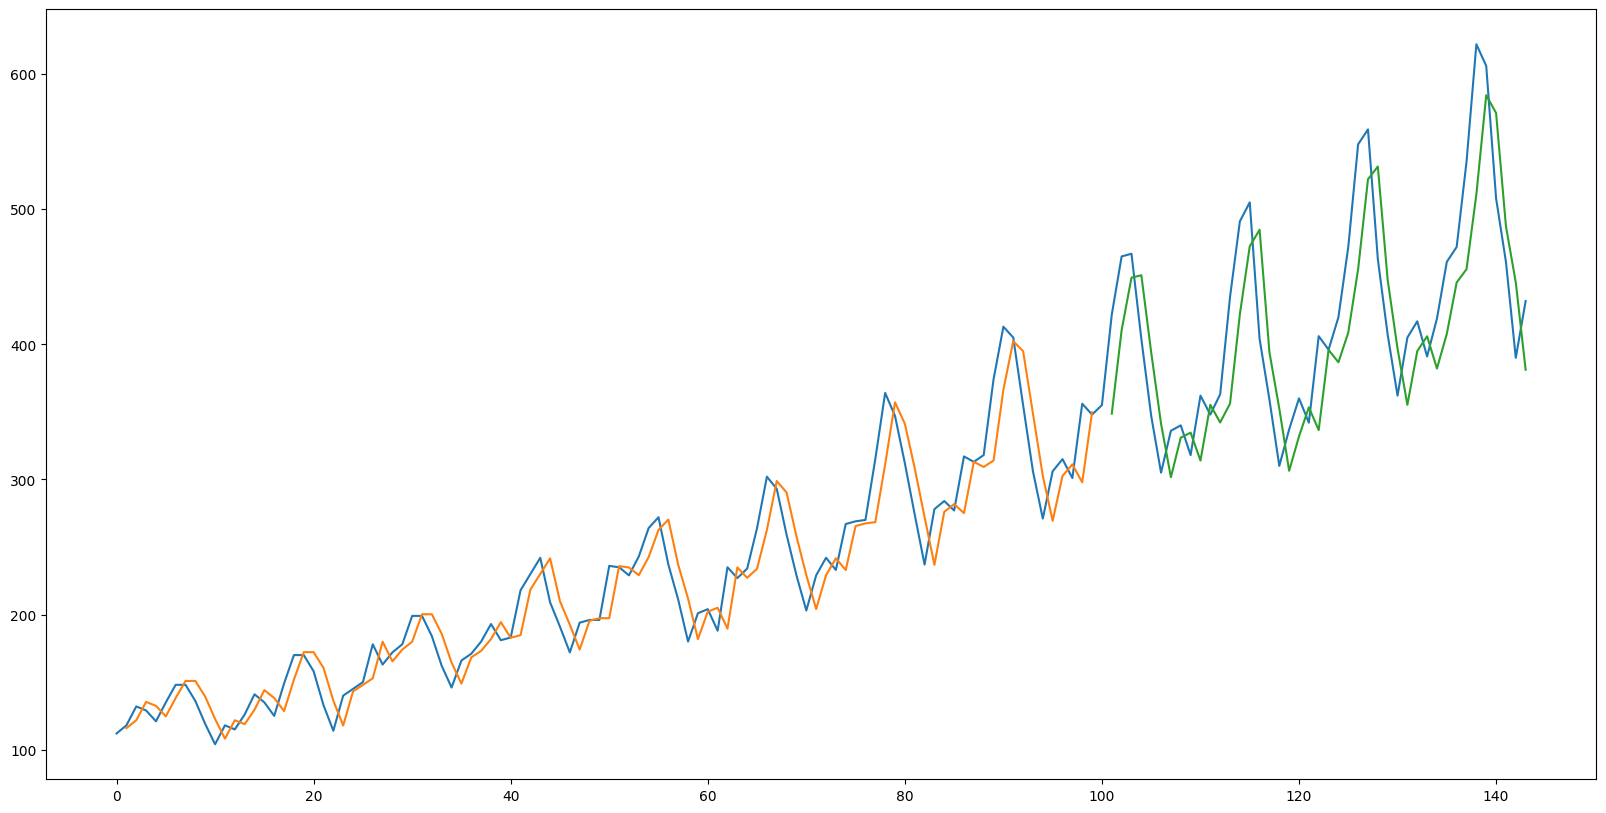

In [53]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

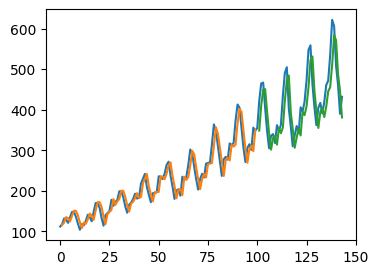

In [54]:
plt.figure(figsize=(4,3))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()